<h1><b>Towards Object-Based Visual SLAM: A Revolution for Urban Tram</b></h1>

In [33]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import json
import sys
import cv2 
from collections import Counter
from collections import defaultdict
from tabulate import tabulate
from math import ceil

In [4]:
%matplotlib inline

# <b>1. EDA (EXPLORATORY DATA ANALYSIS)</b>

In [ ]:
KITTI_ANNOT_PATH = 'KITTI/train/ann'
KITTI_IMG_PATH = 'KITTI/train/img'

In [ ]:
# Function to convert JSON annotations to TXT
def convert_json_to_txt(json_path, txt_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    with open(txt_path, 'w') as f:
        objects = data.get('objects', [])
        for obj in objects:
            class_name = obj.get('label', 'unknown')
            bbox = obj.get('bbox', [])
            if bbox:
                x_min, y_min, width, height = bbox
                x_max = x_min + width
                y_max = y_min + height
                f.write(f'{class_name} {x_min} {y_min} {x_max} {y_max}\n')

<h5>1.1 KITTI Object Detection Benchmark</h5>

In [7]:
# Convert all JSON annotations to TXT for KITTI
for json_file in os.listdir(KITTI_ANNOT_PATH):
    if json_file.endswith('.json'):
        json_file_path = os.path.join(KITTI_ANNOT_PATH, json_file)
        txt_file_path = os.path.join(KITTI_ANNOT_PATH, json_file.replace('.json', '.txt'))
        convert_json_to_txt(json_file_path, txt_file_path)

In [25]:
# EDA for KITTI train set
kitti_data = []

for json_file in os.listdir(KITTI_ANNOT_PATH):
    if json_file.endswith('.json'):
        json_file_path = os.path.join(KITTI_ANNOT_PATH, json_file)
        with open(json_file_path, 'r') as f:
            data = json.load(f)
            # Extract filename (remove .json and add .png once)
            base_name = os.path.splitext(json_file)[0]  # Get base filename without .json
            file_name = f'{base_name}'
            # Extract objects
            objects = data.get('objects', [])
            for obj in objects:
                record = {
                    'file': file_name,
                    'type': obj.get('classTitle', 'unknown'),
                    'occluded': next((tag['value'] for tag in obj.get('tags', []) if tag['name'] == 'occlusion state'), 'unknown'),
                    'bbox_xmin': obj['points']['exterior'][0][0],
                    'bbox_ymin': obj['points']['exterior'][0][1],
                    'bbox_xmax': obj['points']['exterior'][1][0],
                    'bbox_ymax': obj['points']['exterior'][1][1],
                    'dimensions_h': next((float(part) for tag in obj.get('tags', []) if tag['name'] == 'dimensions' for part in tag['value'].split() if part), 0.0),
                    'dimensions_w': next((float(part) for tag in obj.get('tags', []) if tag['name'] == 'dimensions' for part in tag['value'].split() if part), 0.0),
                    'dimensions_l': next((float(part) for tag in obj.get('tags', []) if tag['name'] == 'dimensions' for part in tag['value'].split() if part), 0.0),
                    'location_x': next((float(part) for tag in obj.get('tags', []) if tag['name'] == 'location' for part in tag['value'].split() if part), 0.0),
                    'location_y': next((float(part) for tag in obj.get('tags', []) if tag['name'] == 'location' for part in tag['value'].split() if part), 0.0),
                    'location_z': next((float(part) for tag in obj.get('tags', []) if tag['name'] == 'location' for part in tag['value'].split() if part), 0.0),
                    'rotation_y': next((float(tag['value']) for tag in obj.get('tags', []) if tag['name'] == 'rotation y'), 0.0)
                }
                kitti_data.append(record)

# Convert to DataFrame
kitti_df = pd.DataFrame(kitti_data)

In [9]:
kitti_df.head()

,file,type,occluded,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,dimensions_h,dimensions_w,dimensions_l,location_x,location_y,location_z,rotation_y
0,002126.png,car,fully visible,601,183,675,254,1.56,1.56,1.56,0.59,0.59,0.59,-1.57
1,002126.png,car,fully visible,748,175,905,254,1.54,1.54,1.54,4.90,4.90,4.90,-0.78
2,002126.png,car,partly occluded,698,181,785,225,1.52,1.52,1.52,4.96,4.96,4.96,-0.78
3,002126.png,car,largely occluded,671,183,747,215,1.39,1.39,1.39,4.63,4.63,4.63,-0.76
4,002126.png,car,fully visible,0,208,64,297,1.34,1.34,1.34,-10.44,-10.44,-10.44,1.57


In [10]:
kitti_df.describe()

,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,dimensions_h,dimensions_w,dimensions_l,location_x,location_y,location_z,rotation_y
count,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000
mean,522.935563,172.390340,613.980719,235.388084,1.103321,1.103321,1.103321,-219.217034,-219.217034,-219.217034,-2.268226
std,264.862178,21.613621,263.531846,52.993629,1.176088,1.176088,1.176088,412.046372,412.046372,412.046372,4.353582
min,0.000000,0.000000,8.000000,128.000000,-1.000000,-1.000000,-1.000000,-1000.000000,-1000.000000,-1000.000000,-10.000000
25%,366.000000,166.000000,454.000000,199.000000,1.360000,1.360000,1.360000,-17.940000,-17.940000,-17.940000,-2.720000
50%,547.000000,175.000000,585.000000,217.000000,1.500000,1.500000,1.500000,-4.310000,-4.310000,-4.310000,-1.560000
75%,684.000000,182.000000,744.000000,253.000000,1.680000,1.680000,1.680000,2.550000,2.550000,2.550000,1.540000
max,1241.000000,349.000000,1241.000000,375.000000,4.200000,4.200000,4.200000,40.060000,40.060000,40.060000,3.140000


In [22]:
bbox_stats = kitti_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].describe().round(2)

print('\nSummary Statistics for Bounding Box Dimensions:')
print(tabulate(bbox_stats, headers='keys', tablefmt='pretty'))


Summary Statistics for Bounding Box Dimensions:
+-------+-----------+-----------+-----------+-----------+
|       | bbox_xmin | bbox_ymin | bbox_xmax | bbox_ymax |
+-------+-----------+-----------+-----------+-----------+
| count |  51865.0  |  51865.0  |  51865.0  |  51865.0  |
| mean  |  522.94   |  172.39   |  613.98   |  235.39   |
|  std  |  264.86   |   21.61   |  263.53   |   52.99   |
|  min  |    0.0    |    0.0    |    8.0    |   128.0   |
|  25%  |   366.0   |   166.0   |   454.0   |   199.0   |
|  50%  |   547.0   |   175.0   |   585.0   |   217.0   |
|  75%  |   684.0   |   182.0   |   744.0   |   253.0   |
|  max  |  1241.0   |   349.0   |  1241.0   |   375.0   |
+-------+-----------+-----------+-----------+-----------+


/var/folders/wk/m8g2bm7n2z92gnr31mq5bbm40000gn/T/ipykernel_48502/3643683296.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


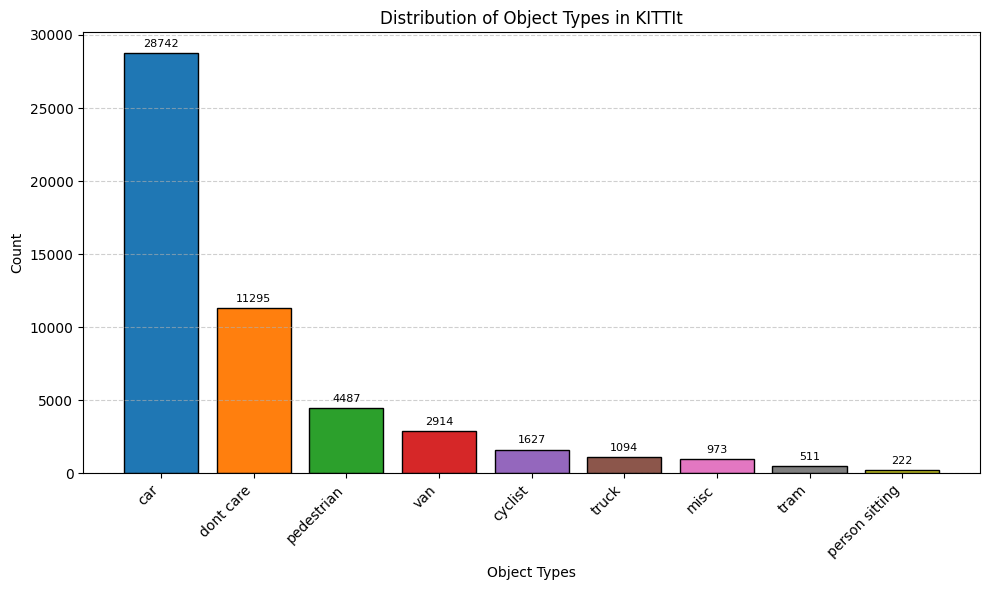

In [11]:
# 1. Bar Chart: Distribution of Object Types

counts = kitti_df['type'].value_counts()
labels = counts.index.tolist()
values = counts.values
cmap = plt.get_cmap('tab10')
colors = cmap.colors[:len(labels)]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, values, color=colors, edgecolor='black')
ax.set_title('Distribution of Object Types in KITTIt')
ax.set_xlabel('Object Types')
ax.set_ylabel('Count')
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

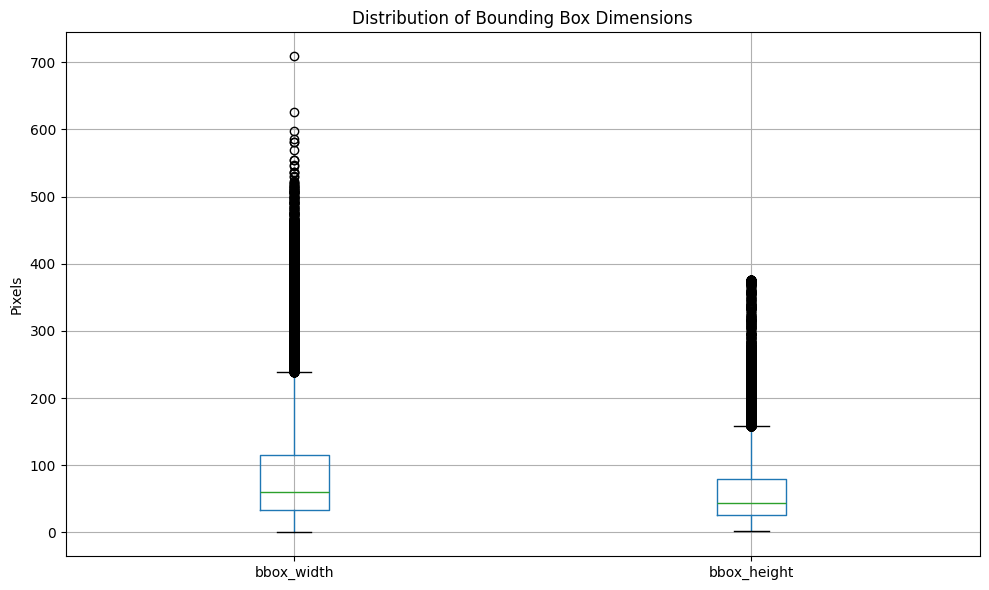

In [12]:
# 2. Box Plot: Distribution of Bounding Box Dimensions
kitti_df['bbox_width'] = kitti_df['bbox_xmax'] - kitti_df['bbox_xmin']
kitti_df['bbox_height'] = kitti_df['bbox_ymax'] - kitti_df['bbox_ymin']
plt.figure(figsize=(10, 6))
kitti_df[['bbox_width', 'bbox_height']].boxplot()
plt.title('Distribution of Bounding Box Dimensions')
plt.ylabel('Pixels')
plt.tight_layout()
plt.show()

Sample File: 002126.png
Sample Image Path: KITTI/train/img/002126.png


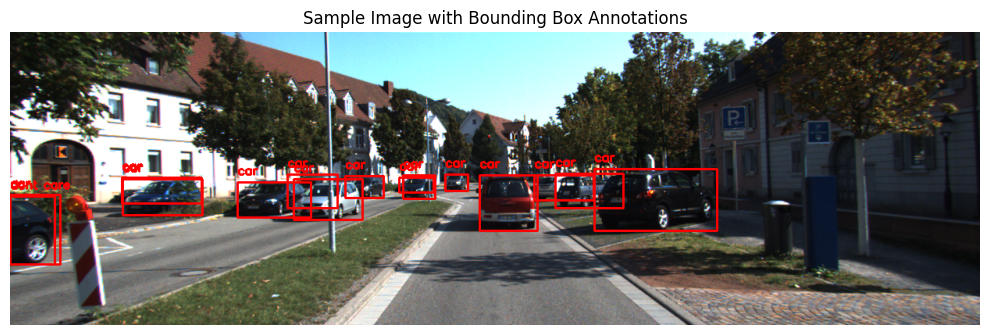

In [ ]:
# 5. Sample Image with Annotations
sample_file = kitti_df['file'].iloc[0]  # Take the first file as a sample
print(f'Sample File: {sample_file}')
sample_img_path = os.path.join(KITTI_IMG_PATH, sample_file)
print(f'Sample Image Path: {sample_img_path}')
if os.path.exists(sample_img_path):
    img = cv2.imread(sample_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
    # Filter annotations for the sample file
    annotations = kitti_df[kitti_df['file'] == sample_file]
    for index, row in annotations.iterrows():
        cv2.rectangle(img, (int(row['bbox_xmin']), int(row['bbox_ymin'])),
                     (int(row['bbox_xmax']), int(row['bbox_ymax'])), (255, 0, 0), 2)
        cv2.putText(img, row['type'], (int(row['bbox_xmin']), int(row['bbox_ymin'] - 10)),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title('Sample Image with Bounding Box Annotations')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f'Sample image {sample_img_path} not found.')

In [21]:
kitti_df

,file,type,occluded,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,dimensions_h,dimensions_w,dimensions_l,location_x,location_y,location_z,rotation_y,bbox_width,bbox_height
0,002126.png,car,fully visible,601,183,675,254,1.56,1.56,1.56,0.59,0.59,0.59,-1.57,74,71
1,002126.png,car,fully visible,748,175,905,254,1.54,1.54,1.54,4.90,4.90,4.90,-0.78,157,79
2,002126.png,car,partly occluded,698,181,785,225,1.52,1.52,1.52,4.96,4.96,4.96,-0.78,87,44
3,002126.png,car,largely occluded,671,183,747,215,1.39,1.39,1.39,4.63,4.63,4.63,-0.76,76,32
4,002126.png,car,fully visible,0,208,64,297,1.34,1.34,1.34,-10.44,-10.44,-10.44,1.57,64,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51860,002556.png,dont care,unknown,490,176,545,197,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00,55,21
51861,002556.png,dont care,unknown,773,165,796,208,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00,23,43
51862,005497.png,car,fully visible,597,175,664,240,1.61,1.61,1.61,0.50,0.50,0.50,-1.55,67,65
51863,005497.png,tram,fully visible,702,149,728,185,3.63,3.63,3.63,11.54,11.54,11.54,1.68,26,36


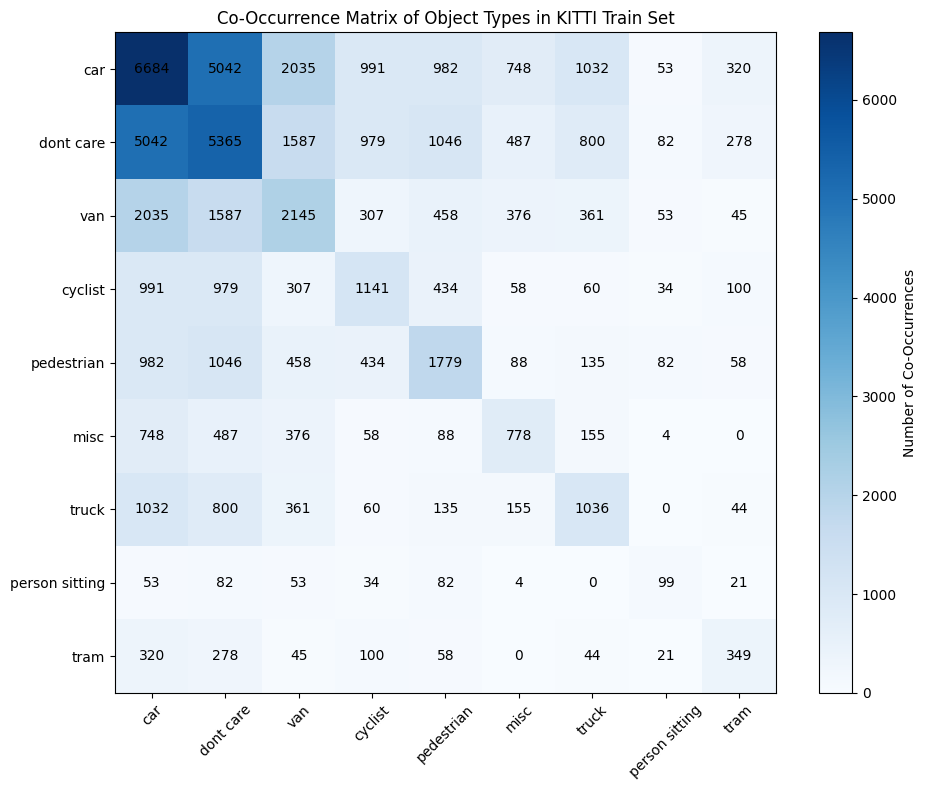

In [30]:
# 1. Co-Occurrence Matrix
# Group by file to get all types per image
types_per_file = kitti_df.groupby('file')['type'].apply(list).to_dict()

# Create a dictionary to count co-occurrences per image
co_occurrence = defaultdict(set)
for file, types in types_per_file.items():
    for obj_type in types:
        co_occurrence[obj_type].add(file)

# Build co-occurrence matrix
object_types = kitti_df['type'].unique()
co_matrix = pd.DataFrame(0, index=object_types, columns=object_types, dtype=int)

for i, type1 in enumerate(object_types):
    for j, type2 in enumerate(object_types):
        if i <= j:  # Avoid double-counting and fill only upper triangle
            common_files = co_occurrence[type1] & co_occurrence[type2]
            co_matrix.iloc[i, j] = len(common_files)
            if i != j:  # Mirror the upper triangle to lower triangle
                co_matrix.iloc[j, i] = len(common_files)

plt.figure(figsize=(10, 8))
plt.imshow(co_matrix, cmap='Blues', interpolation='nearest')
plt.title('Co-Occurrence Matrix of Object Types in KITTI Train Set')
plt.xticks(ticks=range(len(object_types)), labels=object_types, rotation=45)
plt.yticks(ticks=range(len(object_types)), labels=object_types)
plt.colorbar(label='Number of Co-Occurrences')
for i in range(len(object_types)):
    for j in range(len(object_types)):
        plt.text(j, i, co_matrix.iloc[i, j], ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

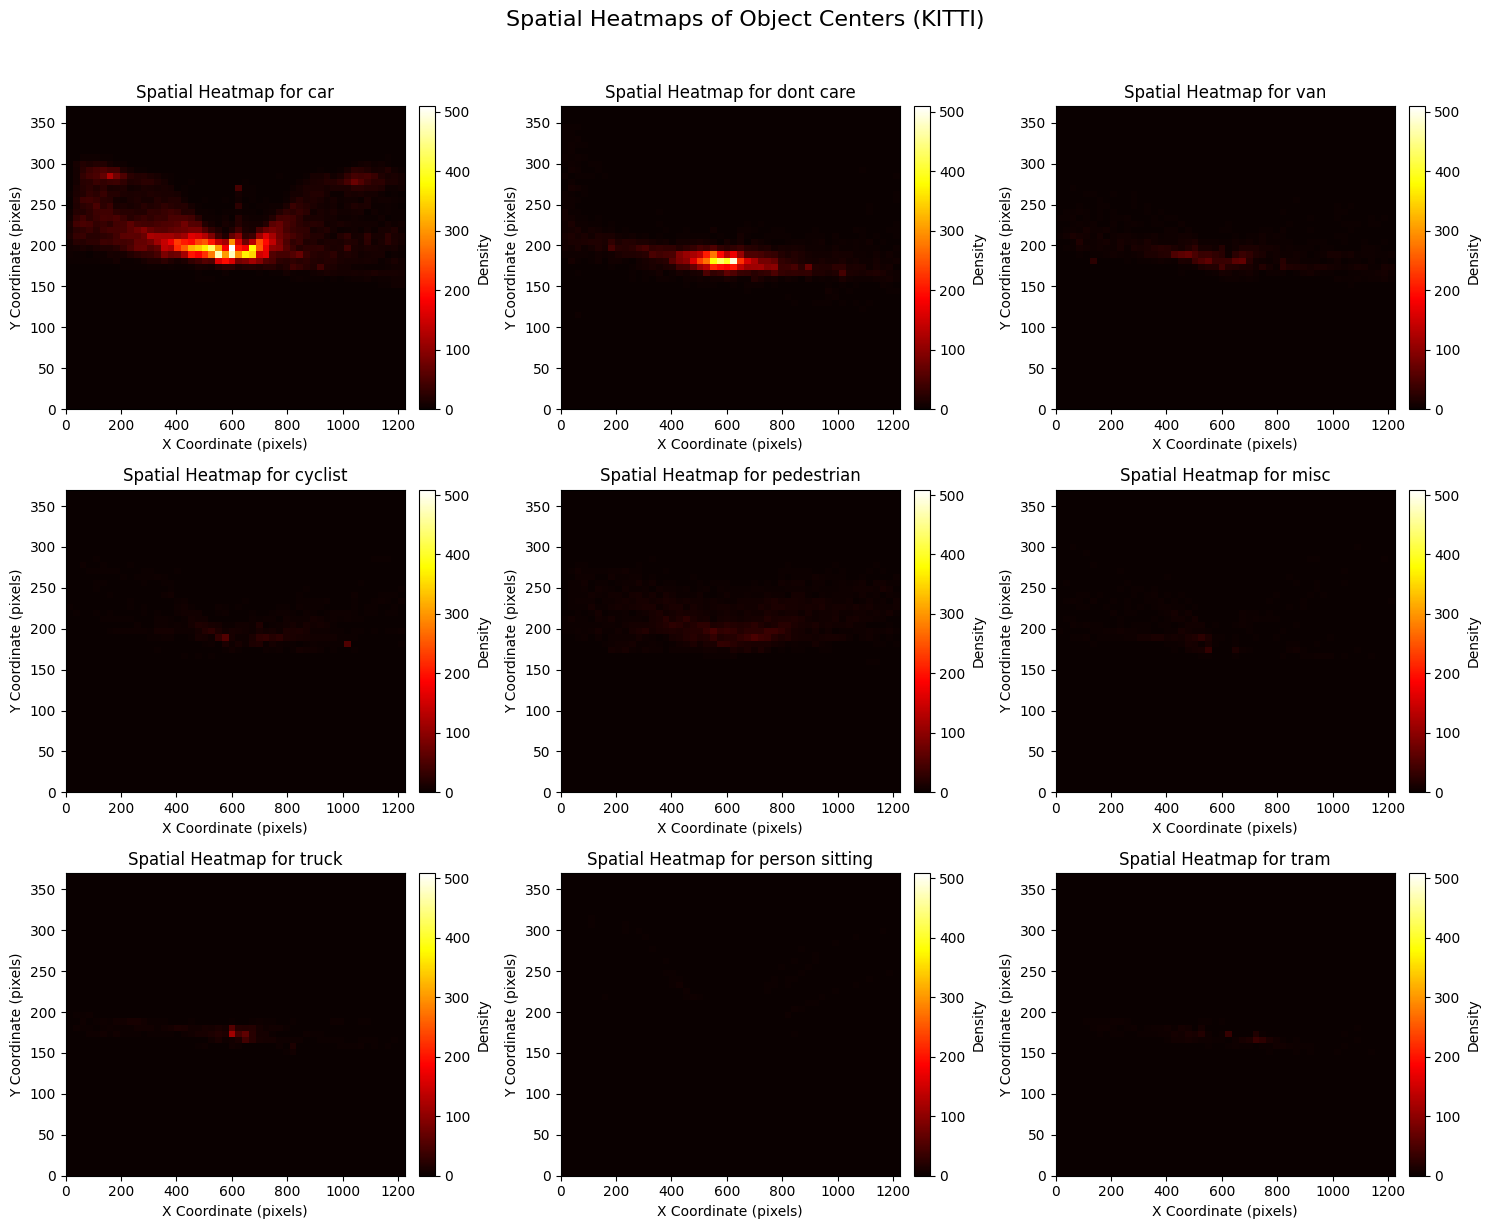

In [36]:
# 2. Spatial Heatmap for each object type
image_width = 1224  # Typical KITTI image width (adjust if different)
image_height = 370  # Typical KITTI image height (adjust if different)

# Re-extract data for spatial heatmaps with individual object details
kitti_data_individual = []
for json_file in os.listdir(KITTI_ANNOT_PATH):
    if json_file.endswith('.json'):
        json_file_path = os.path.join(KITTI_ANNOT_PATH, json_file)
        with open(json_file_path, 'r') as f:
            data = json.load(f)
            base_name = os.path.splitext(json_file)[0]
            file_name = f"{base_name}.png"
            objects = data.get('objects', [])
            for obj in objects:
                record = {
                    'file': file_name,
                    'type': obj.get('classTitle', 'unknown'),
                    'bbox_xmin': obj['points']['exterior'][0][0],
                    'bbox_ymin': obj['points']['exterior'][0][1],
                    'bbox_xmax': obj['points']['exterior'][1][0],
                    'bbox_ymax': obj['points']['exterior'][1][1]
                }
                kitti_data_individual.append(record)

kitti_df_individual = pd.DataFrame(kitti_data_individual)

# for obj_type in object_types:
#     df_type = kitti_df_individual[kitti_df_individual['type'] == obj_type]
#     if not df_type.empty:
#         x_centers = [(row['bbox_xmin'] + row['bbox_xmax']) / 2 for _, row in df_type.iterrows()]
#         y_centers = [(row['bbox_ymin'] + row['bbox_ymax']) / 2 for _, row in df_type.iterrows()]
        
#         heatmap, xedges, yedges = np.histogram2d(x_centers, y_centers, bins=[50, 50], range=[[0, image_width], [0, image_height]])

#         plt.figure(figsize=(6, 4))
#         plt.imshow(heatmap.T, cmap='hot', origin='lower', extent=[0, image_width, 0, image_height], aspect='auto')
#         plt.title(f'Spatial Heatmap for {obj_type}')
#         plt.xlabel('X Coordinate (pixels)')
#         plt.ylabel('Y Coordinate (pixels)')
#         plt.colorbar(label='Density')
#         plt.tight_layout()
#         plt.show()

# 1. Prepare parameters
image_width   = 1224
image_height  = 370
object_types  = kitti_df_individual['type'].unique().tolist()
n_types       = len(object_types)
n_cols        = 3
n_rows        = ceil(n_types / n_cols)

# 2. Precompute all heatmaps (so we can share vmin/vmax)
all_heatmaps = []
for t in object_types:
    df_t = kitti_df_individual[kitti_df_individual['type'] == t]
    x_centers = (df_t['bbox_xmin'] + df_t['bbox_xmax']) / 2
    y_centers = (df_t['bbox_ymin'] + df_t['bbox_ymax']) / 2
    heatmap, _, _ = np.histogram2d(
        x_centers, y_centers,
        bins=[50, 50],
        range=[[0, image_width], [0, image_height]]
    )
    all_heatmaps.append(heatmap.T)  # transpose now for origin='lower'

vmin = min(h.min() for h in all_heatmaps)
vmax = max(h.max() for h in all_heatmaps)

# 3. Create grid of subplots
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 4),
    sharex=False, sharey=False
)
axes = axes.flatten()

# 4. Plot each heatmap with its own colourbar
for idx, (ax, obj_type) in enumerate(zip(axes, object_types)):
    hm = all_heatmaps[idx]
    im = ax.imshow(
        hm,
        cmap='hot',
        origin='lower',
        extent=[0, image_width, 0, image_height],
        aspect='auto',
        vmin=vmin, vmax=vmax
    )
    ax.set_title(f'Spatial Heatmap for {obj_type}')
    ax.set_xlabel('X Coordinate (pixels)')
    ax.set_ylabel('Y Coordinate (pixels)')
    
    # 4a. Add a colourbar pinned to this subplot
    cbar = fig.colorbar(
        im, ax=ax,
        fraction=0.046,  # width of colorbar as fraction of subplot
        pad=0.04         # space between plot and bar
    )
    cbar.set_label('Density')

# 5. Turn off any unused axes
for j in range(n_types, len(axes)):
    axes[j].axis('off')

fig.suptitle('Spatial Heatmaps of Object Centers (KITTI)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


<h5>1.2 BDD100K</h5>

<h5>1.3 COMPARISON</h5>